In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics.scorer import make_scorer
from sklearn import *
import scipy as sp
import matplotlib.pyplot as plt
import xgboost
import lightgbm as lgbm
import catboost
import copy
import warnings
warnings.filterwarnings("ignore")

# Content
1. read data and investiagte data
     - target variable distribution
     - transform categorial values
3. check dummy classfier and ohter well known classifiers
4. check RF classifier params and plots
5. check boost classifier params and plots
6. check RF regressor params and plots
7. check boost regressor params and plots
8. check dummy regressor

In [2]:
def smape(A, F):
    return -100.0/float(len(A)) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape_scorer = make_scorer(smape, greater_is_better=True)

# Read and investigate data

In [54]:
# data are provided in https://www.kaggle.com/c/new-product-demand-forecasting/leaderboard
df = pd.read_csv("train.csv",sep=';',index_col="ID")
df_test = pd.read_csv("test.csv",sep=';',index_col="ID")
y = df["DEMAND"]
df.drop(["DEMAND"],inplace=True,axis=1)

### Target variable distibution

In [ ]:
y.hist(figsize=(15,6), bins=21)

In [ ]:
np.log(y).hist(figsize=(15,6), bins=21)

* Conclusion: there are two classes in target variable (unballanced classes) 

### Transform categorial variables

In [55]:
ones = sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore")
int_values = df.columns[df.dtypes=="int64"]
num_values = list(df.columns[df.dtypes=="float64"])
cat_val = list(df.columns[df.dtypes=="O"])
cat_val.extend(int_values)

In [56]:
def transform(data_input,y, fit=False):    
    data_input[num_values] = data_input[num_values].fillna(0)
    data_input[cat_val] = data_input[cat_val].fillna("?")
    
    if(fit):
        cat_transformed = ones.fit_transform(data_input[cat_val])
    else:
        cat_transformed = ones.transform(data_input[cat_val])
    
    data = sp.sparse.hstack((cat_transformed,data_input[num_values].values))
    
#     y_bin = copy.deepcopy(y)
#     y_bin[y_bin<0.01] = 0
#     y_bin[y_bin>=0.01] = 1
    
    return data, y, y_bin

# separate target and features
dataTrain_full, yTrain_full, yTrain_bin = transform(df,y, fit=True)

# train-test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataTrain_full,yTrain_full,test_size = 0.2)

In [13]:
X_train_f, X_test_f, y_train_f, y_test_F = sklearn.model_selection.train_test_split(dataTest_full,range(len(dataTest_full)),test_size = 0.0)

In [50]:
def transform_1(data_input,y,fit=False):    
    data_input[num_values] = data_input[num_values].fillna(0)
    data_input[cat_val] = data_input[cat_val].fillna("?")
    
    if(fit):
        cat_transformed = ones.fit_transform(data_input[cat_val])
    else:
        cat_transformed = ones.transform(data_input[cat_val])
    
    data = sp.sparse.hstack((cat_transformed,data_input[num_values].values))
    
    return data

def predict(data_to_predict):
    data_pre = data_to_predict.toarray()
    ans = reg.predict(data_pre)
    return ans

dataTest_full=transform_1(df_test,np.array(0),False)

(11296, 1511)

# Check direct regressors

### Check dummy regressor

In [23]:
reg = sklearn.dummy.DummyRegressor()
reg.fit(X_train,y_train)
pred = reg.predict(X_test)
print(-smape(y_test,pred))

124.59272013685728


### Check Decision Tree

In [27]:
reg = sklearn.tree.DecisionTreeRegressor()
reg.fit(X_train,y_train)
pred = reg.predict(X_test)
print(-smape(y_test,pred))

76.46464244833781


In [28]:
pred = predict(dataTest_full)

out = pd.DataFrame(pred,columns=["Demand"])
out.to_csv("DT_output.csv")
out.shape

(11296, 1)

### Check best params for direct RF regressor

In [73]:
def plot_gs_results(gs_model, params, check_params, model_name = ''):
    plt.figure(figsize=(12,6))
    plt.title(model_name + " dependency from "+str(check_params))
    plt.plot(params[check_params], gs_model.cv_results_["mean_train_score"],"o-",label="train")
    plt.plot(params[check_params], gs_model.cv_results_["mean_test_score"],"o-",label="test")
    plt.xlabel(check_params)
    plt.ylabel(metric)
    plt.legend()
    plt.show()

def gs_regressor_params(parameters ={}, check_parameter={}, metric= smape_scorer, reg=None, n_splits=1, test_size=0.20):
#     parameters = {'max_depth':range(1,50,5), 'n_estimators':[8]}
#     check_param = "max_depth"
#     # metric = "neg_mean_absolute_error"
#     metric = smape_scorer
    cv=sklearn.model_selection.ShuffleSplit(test_size=test_size, n_splits=n_splits)
#     reg = sklearn.ensemble.RandomForestRegressor(n_jobs=3)
    gs_reg = sklearn.model_selection.GridSearchCV(reg, parameters, cv=cv,scoring=metric)
    gs_reg.fit(X_train,y_train)
    plot_gs_results(gs_model=gs_reg, params=parameters, check_params = check_parameter, model_name=str(reg))

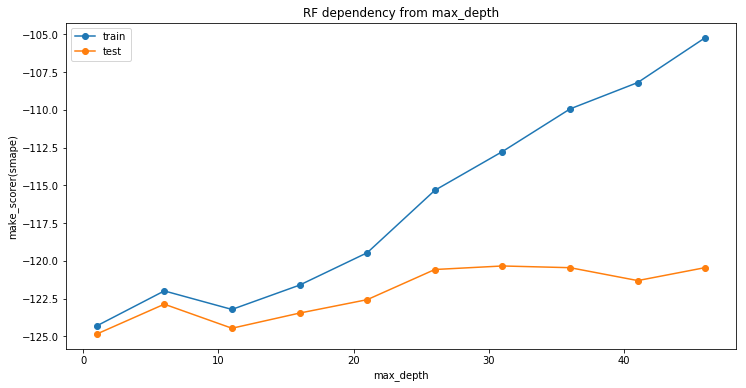

In [31]:
gs_regressor_params(parameters ={'max_depth':range(1,50,5), 'n_estimators':[8]},
                    check_parameter='max_depth',reg= sklearn.ensemble.RandomForestRegressor(n_jobs=3))

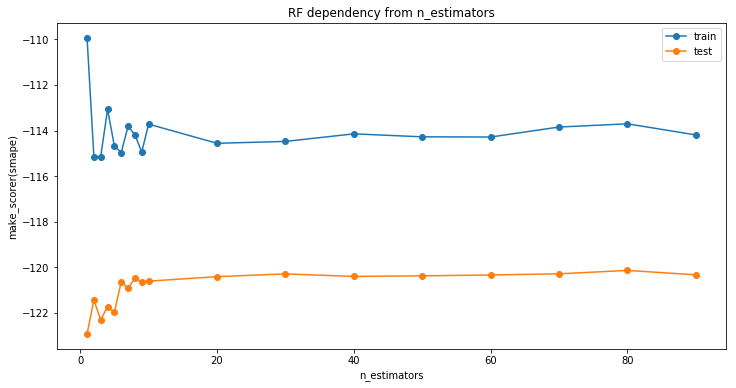

In [58]:
gs_regressor_params(parameters ={'max_depth':[33], 'n_estimators':list(range(1,10))+ list(range(10,100,10))},
                    check_parameter='n_estimators',reg= sklearn.ensemble.RandomForestRegressor(n_jobs=3))

In [52]:
final_rf = sklearn.ensemble.RandomForestRegressor(max_depth=33, n_estimators=10,n_jobs=3)
final_rf.fit(X_train,y_train)
pred = final_rf.predict(X_test)
print(str(-smape(y_test,pred))+"%")

116.87251137149525%


### Check XGBoost

[01:22:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

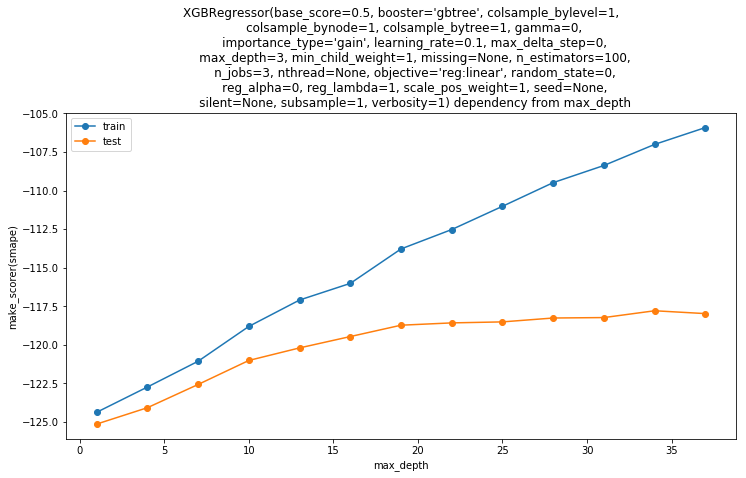

In [75]:
gs_regressor_params(parameters ={'max_depth':range(1,40,3), 'n_estimators':[40]},
                    check_parameter='max_depth',reg= xgboost.XGBRegressor(n_jobs=3))

[01:26:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

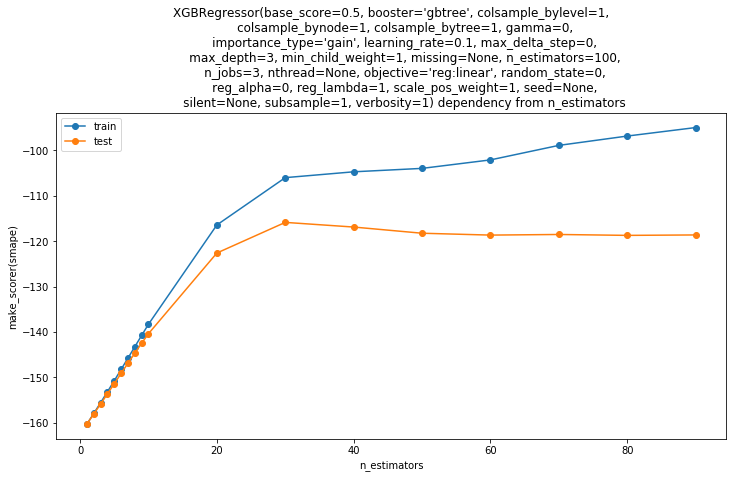

In [77]:
gs_regressor_params(parameters ={'max_depth':[40], 'n_estimators':list(range(1,10))+ list(range(10,100,10))},
                    check_parameter='n_estimators',reg= xgboost.XGBRegressor(n_jobs=3))

In [60]:
final_rf = xgboost.XGBRegressor(n_jobs=3)(max_depth=35, n_estimators=10,n_jobs=3)
final_rf.fit(X_train,y_train)
pred = final_rf.predict(X_test)
print(str(-smape(y_test,pred))+"%")

123.05955538760993%


### Check catboost

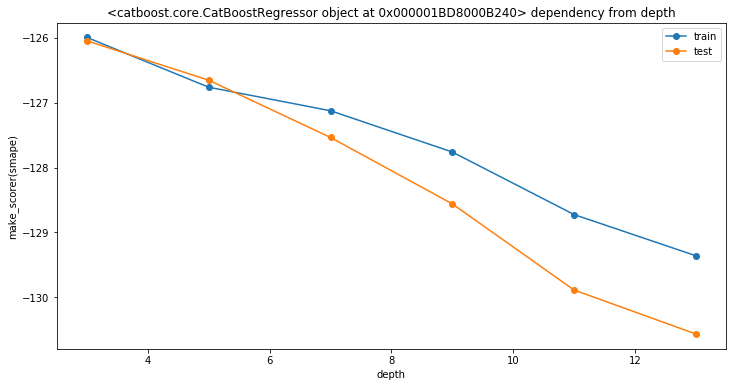

In [81]:
gs_regressor_params(parameters ={'iterations':[40], 'learning_rate':[1], 'depth':range(3,15,2)},
                    check_parameter='depth',reg= catboost.CatBoostRegressor(verbose=False), n_splits=10)

In [ ]:
gs_regressor_params(parameters ={'iterations':[40], 'learning_rate':[1], 'depth':range(3,10,2)},
                    check_parameter='depth',reg= catboost.CatBoostRegressor())

# Classificator model selection

### Check best params for RF

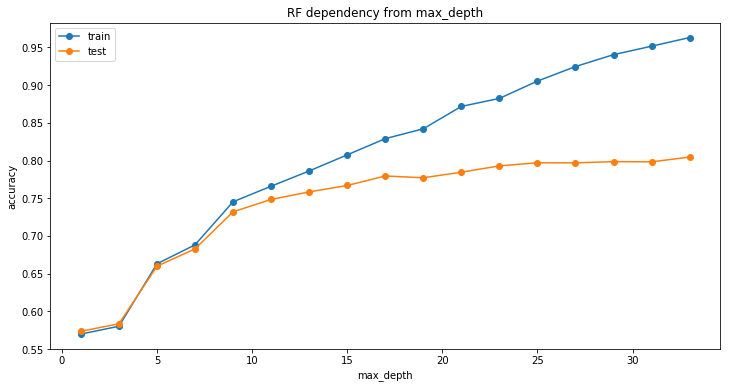

In [122]:
parameters = {'max_depth':range(1,34,2), 'n_estimators':[40]}
check_param = "max_depth"
metric = "accuracy"

cv=sklearn.model_selection.ShuffleSplit(test_size=0.20, n_splits=1)
reg = sklearn.ensemble.RandomForestClassifier(n_jobs=3)
clf = sklearn.model_selection.GridSearchCV(reg, parameters, cv=cv,scoring=metric)
clf.fit(dataTrain_full,y_bin_full)
plt.figure(figsize=(12,6))
plt.title("RF dependency from "+str(check_param))
plt.plot(parameters[check_param],clf.cv_results_["mean_train_score"],"o-",label="train")
plt.plot(parameters[check_param],clf.cv_results_["mean_test_score"],"o-",label="test")
plt.xlabel(check_param)
plt.ylabel(metric)
plt.legend()
plt.show()

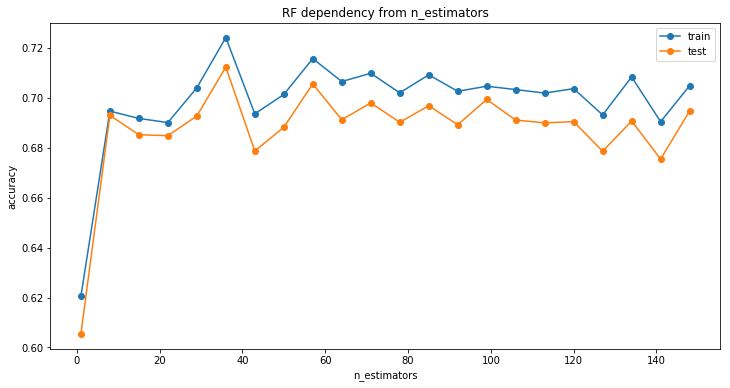

In [123]:
parameters = {'max_depth':[7], 'n_estimators':range(1,150,7)}
check_param = "n_estimators"
metric = "accuracy"

cv=sklearn.model_selection.ShuffleSplit(test_size=0.20, n_splits=1)
reg = sklearn.ensemble.RandomForestClassifier(n_jobs=3)
clf = sklearn.model_selection.GridSearchCV(reg, parameters, cv=cv,scoring=metric)
clf.fit(dataTrain_full,y_bin_full)
plt.figure(figsize=(12,6))
plt.title("RF dependency from "+str(check_param))
plt.plot(parameters[check_param],clf.cv_results_["mean_train_score"],"o-",label="train")
plt.plot(parameters[check_param],clf.cv_results_["mean_test_score"],"o-",label="test")
plt.xlabel(check_param)
plt.ylabel(metric)
plt.legend()
plt.show()

In [128]:
reg = sklearn.ensemble.RandomForestClassifier(n_estimators=40,max_depth=17,n_jobs=3)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataTrain_full,y_bin_full,test_size = 0.2)
reg.fit(X_train,y_train)
pred = reg.predict(X_test)
sklearn.metrics.accuracy_score(y_test,pred)

0.7675

### check Boost best params

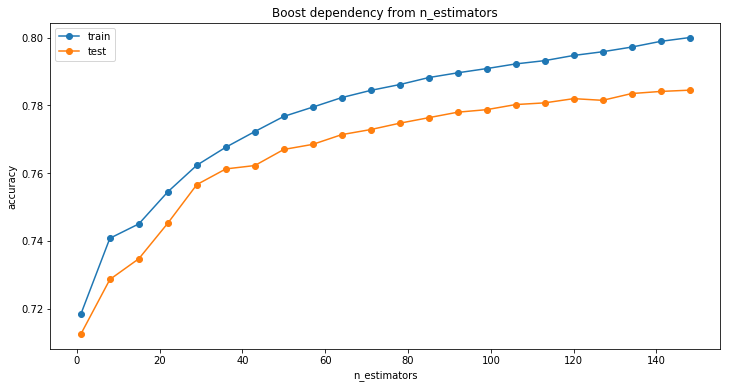

In [127]:
parameters = {'max_depth':[3], 'n_estimators':range(1,150,7)}
check_param = "n_estimators"
metric = "accuracy"

cv=sklearn.model_selection.ShuffleSplit(test_size=0.20, n_splits=1)
reg = xgboost.XGBClassifier(n_jobs=3)
clf = sklearn.model_selection.GridSearchCV(reg, parameters, cv=cv,scoring=metric)
clf.fit(dataTrain_full,y_bin_full)
plt.figure(figsize=(12,6))
plt.title("Boost dependency from "+str(check_param))
plt.plot(parameters[check_param],clf.cv_results_["mean_train_score"],"o-",label="train")
plt.plot(parameters[check_param],clf.cv_results_["mean_test_score"],"o-",label="test")
plt.xlabel(check_param)
plt.ylabel(metric)
plt.legend()
plt.show()

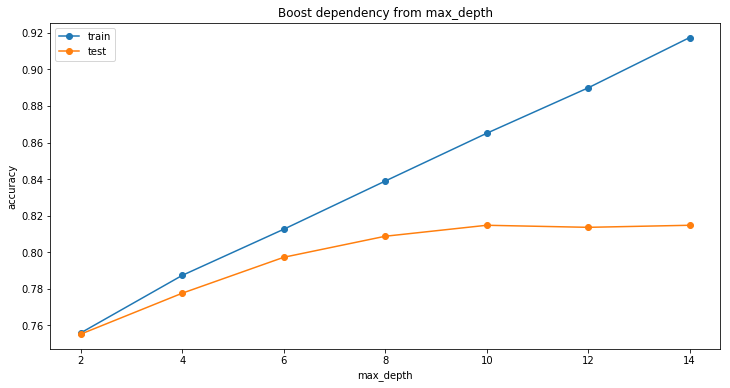

In [131]:
parameters = {'max_depth':range(2,16,2), 'n_estimators':[50]}
check_param = "max_depth"
metric = "accuracy"

cv=sklearn.model_selection.ShuffleSplit(test_size=0.20, n_splits=1)
reg = xgboost.XGBClassifier(n_jobs=3)
clf = sklearn.model_selection.GridSearchCV(reg, parameters, cv=cv,scoring=metric)
clf.fit(dataTrain_full,y_bin_full)
plt.figure(figsize=(12,6))
plt.title("Boost dependency from "+str(check_param))
plt.plot(parameters[check_param],clf.cv_results_["mean_train_score"],"o-",label="train")
plt.plot(parameters[check_param],clf.cv_results_["mean_test_score"],"o-",label="test")
plt.xlabel(check_param)
plt.ylabel(metric)
plt.legend()
plt.show()

In [133]:
reg = xgboost.XGBClassifier(max_depth=10,n_estimators=50,n_jobs=3)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataTrain_full,y_bin_full,test_size = 0.2)
reg.fit(X_train,y_train)
pred = reg.predict(X_test)
sklearn.metrics.accuracy_score(y_test,pred)

0.819625

# Regressor model selection

In [6]:
# dataTrain_full,yTrain_full,y_bin_full
mask = np.where(y_bin_full>0.5)
data_regressor = dataTrain_full.toarray()[mask]
y_regressor = yTrain_full.iloc[mask].values

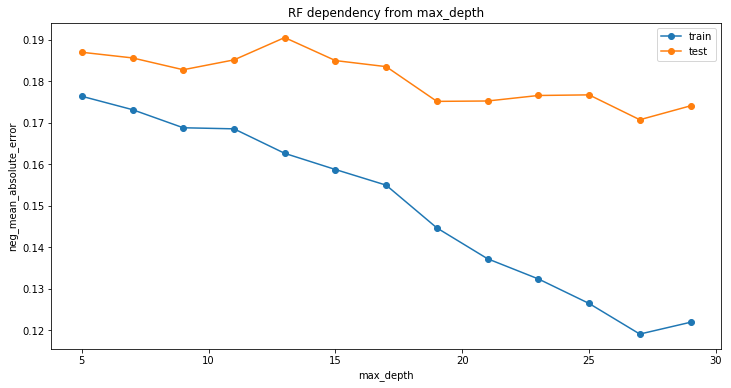

In [7]:
parameters = {'max_depth':range(5,30,2), 'n_estimators':[5]}
check_param = "max_depth"
metric = "neg_mean_absolute_error"

cv=sklearn.model_selection.ShuffleSplit(test_size=0.20, n_splits=1)
reg = sklearn.ensemble.RandomForestRegressor(n_jobs=3)
clf = sklearn.model_selection.GridSearchCV(reg, parameters, cv=cv,scoring=metric)
clf.fit(data_regressor,y_regressor)
plt.figure(figsize=(12,6))
plt.title("RF dependency from "+str(check_param))
plt.plot(parameters[check_param],-clf.cv_results_["mean_train_score"],"o-",label="train")
plt.plot(parameters[check_param],-clf.cv_results_["mean_test_score"],"o-",label="test")
plt.xlabel(check_param)
plt.ylabel(metric)
plt.legend()
plt.show()

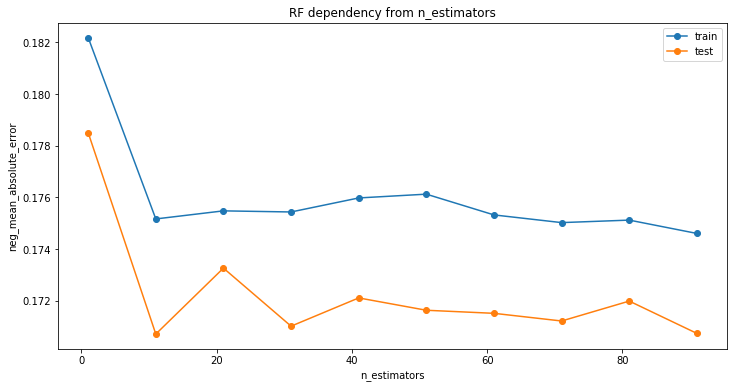

In [8]:
parameters = {'max_depth':[7], 'n_estimators':range(1,100,10)}
check_param = "n_estimators"
metric = "neg_mean_absolute_error"

cv=sklearn.model_selection.ShuffleSplit(test_size=0.20, n_splits=1)
reg = sklearn.ensemble.RandomForestRegressor(n_jobs=3)
clf = sklearn.model_selection.GridSearchCV(reg, parameters, cv=cv,scoring=metric)
clf.fit(data_regressor,y_regressor)
plt.figure(figsize=(12,6))
plt.title("RF dependency from "+str(check_param))
plt.plot(parameters[check_param],-clf.cv_results_["mean_train_score"],"o-",label="train")
plt.plot(parameters[check_param],-clf.cv_results_["mean_test_score"],"o-",label="test")
plt.xlabel(check_param)
plt.ylabel(metric)
plt.legend()
plt.show()

### look at xgb


[13:55:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:55:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:55:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:56:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:56:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:58:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

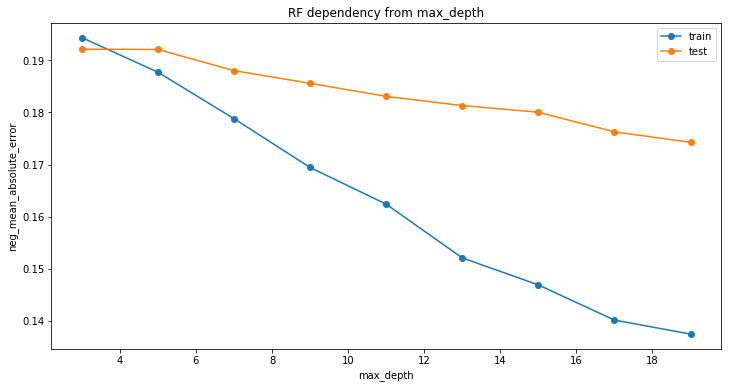

In [192]:
parameters = {'max_depth':range(3,20,2), 'n_estimators':[25]}
check_param = "max_depth"
metric = "neg_mean_absolute_error"

cv=sklearn.model_selection.ShuffleSplit(test_size=0.20, n_splits=1)
reg = xgboost.XGBRegressor(n_jobs=3)
clf = sklearn.model_selection.GridSearchCV(reg, parameters, cv=cv,scoring=metric)
clf.fit(data_regressor,y_regressor)
plt.figure(figsize=(12,6))
plt.title("RF dependency from "+str(check_param))
plt.plot(parameters[check_param],-clf.cv_results_["mean_train_score"],"o-",label="train")
plt.plot(parameters[check_param],-clf.cv_results_["mean_test_score"],"o-",label="test")
plt.xlabel(check_param)
plt.ylabel(metric)
plt.legend()
plt.show()

[13:13:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

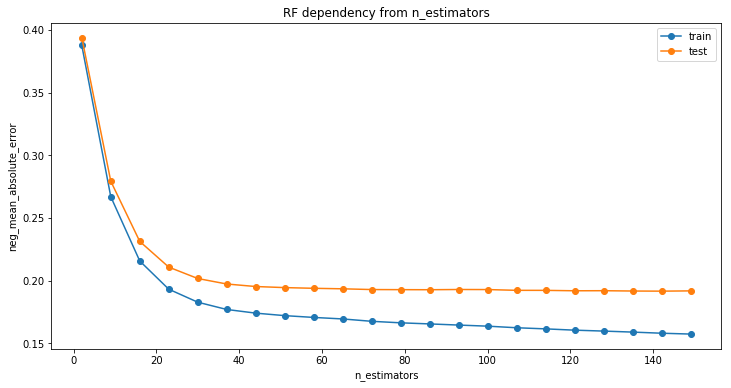

In [187]:
parameters = {'max_depth':[3], 'n_estimators':range(2,150,7)}
check_param = "n_estimators"
metric = "neg_mean_absolute_error"

cv=sklearn.model_selection.ShuffleSplit(test_size=0.20, n_splits=1)
reg = xgboost.XGBRegressor(n_jobs=3)
clf = sklearn.model_selection.GridSearchCV(reg, parameters, cv=cv,scoring=metric)
clf.fit(data_regressor,y_regressor)
plt.figure(figsize=(12,6))
plt.title("RF dependency from "+str(check_param))
plt.plot(parameters[check_param],-clf.cv_results_["mean_train_score"],"o-",label="train")
plt.plot(parameters[check_param],-clf.cv_results_["mean_test_score"],"o-",label="test")
plt.xlabel(check_param)
plt.ylabel(metric)
plt.legend()
plt.show()

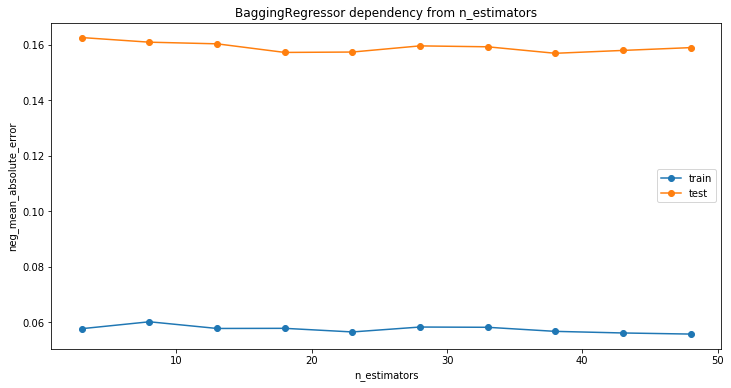

In [9]:
parameters = {'n_estimators':range(3,50,5)}
check_param = "n_estimators"
metric = "neg_mean_absolute_error"

cv=sklearn.model_selection.ShuffleSplit(test_size=0.20, n_splits=1)
reg = sklearn.ensemble.BaggingRegressor(n_jobs=3)
clf = sklearn.model_selection.GridSearchCV(reg, parameters, cv=cv,scoring=metric)
clf.fit(data_regressor,y_regressor)
plt.figure(figsize=(12,6))
plt.title("BaggingRegressor dependency from "+str(check_param))
plt.plot(parameters[check_param],-clf.cv_results_["mean_train_score"],"o-",label="train")
plt.plot(parameters[check_param],-clf.cv_results_["mean_test_score"],"o-",label="test")
plt.xlabel(check_param)
plt.ylabel(metric)
plt.legend()
plt.show()

In [193]:
reg = xgboost.XGBRegressor(max_depth=19,n_estimators=50,n_jobs=3)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data_regressor,y_regressor,test_size = 0.2)
reg.fit(X_train,y_train)
pred = reg.predict(X_test)
print(sklearn.metrics.mean_absolute_error(y_test,pred))
smape(y_test,pred)

[14:00:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.14394150050974455


66.22329664432874

In [13]:
reg = sklearn.dummy.DummyRegressor()
# reg = sklearn.ensemble.BaggingRegressor(n_jobs=3)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data_regressor,y_regressor,test_size = 0.2)
reg.fit(X_train,y_train)
pred = reg.predict(X_test)
print(sklearn.metrics.mean_absolute_error(y_test,pred))
smape(y_test,pred)

0.18439748944452763


88.1912042246442

### Good result for smape metric? probably
then clf = xgboost.XGBClassifier(max_depth=10,n_estimators=50,n_jobs=3)

and if result is 0 - demand is "0.00010000000001"

else: demand is


reg = xgboost.XGBRegressor(max_depth=19,n_estimators=50,n_jobs=3)

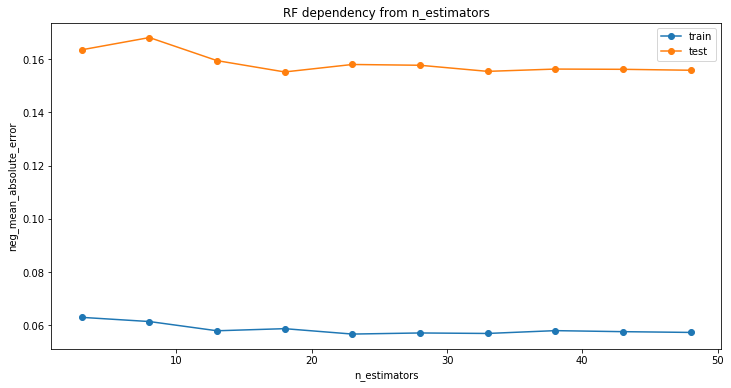